<a href="https://colab.research.google.com/github/JanPastorek/asymmetric_depth/blob/main/asymmetricDepth_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages

In [20]:
import networkx as nx
import itertools
import matplotlib.pyplot as plt
import numpy as np

# Symmetric difference of neighbourhoods

In [2]:
# prompt: # measure and show me the vertices with the minimum of the symmetric difference of the neighbourhoods

def symmetric_difference_neighbors(G, u, v):
    """
    Computes the size of the symmetric difference of the neighborhoods of two vertices.

    Parameters:
    G (nx.Graph): The graph.
    u: The first vertex.
    v: The second vertex.

    Returns:
    int: The size of the symmetric difference of N(u) and N(v).
    """
    nu = set(G.neighbors(u))
    nv = set(G.neighbors(v))
    # Symmetric difference: (A - B) U (B - A)
    return len((nu - nv) | (nv - nu))

def find_min_symmetric_difference_neighbors(G):
    """
    Finds the minimum size of the symmetric difference of the neighborhoods
    between all distinct pairs of vertices and returns the pairs with this minimum size.

    Parameters:
    G (nx.Graph): The graph.

    Returns:
    tuple: (min_size, vertex_pairs)
           min_size (int): The minimum symmetric difference size found.
           vertex_pairs (list): A list of tuples (u, v) where u and v are vertices
                                that have the minimum symmetric difference size.
                                Returns (float('inf'), []) for graphs with less than 2 nodes.
    """
    nodes = list(G.nodes())
    n = len(nodes)
    if n < 2:
        return float('inf'), []

    min_diff = float('inf')
    min_pairs = []

    # Iterate over all unique pairs of vertices
    for i in range(n):
        for j in range(i + 1, n):
            u = nodes[i]
            v = nodes[j]
            diff = symmetric_difference_neighbors(G, u, v)

            if diff < min_diff:
                min_diff = diff
                min_pairs = [(u, v)]
            elif diff == min_diff:
                min_pairs.append((u, v))

    return min_diff, min_pairs

In [7]:
print(2, 1)
for h in range(3,7):
    print(h, 2*(h-2))

2 1
3 2
4 4
5 6
6 8


In [4]:
!pip install pynauty

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 24.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pynauty: filename=pynauty-2.8.8.1-cp311-cp311-linux_x86_64.whl size=181868 sha256=df1241888a333c5a61652fe651fce0ad3c9211fcc00a872838a1161bf498ea9d
  Stored in directory: /root/.cache/pip/wheels/c1/e3/ba/722f2d9187889ac73ce949422b5b698450d8d1390b479adab8
Successfully built pynauty


# Asymmetric depth

In [5]:
import itertools
from typing import Dict, Tuple

# pynauty is the gold standard for graph isomorphism and canonical labeling.
try:
    import pynauty
except ImportError:
    print("Error: pynauty library not found. Please install it using 'pip install pynauty'")
    exit()

def _get_canonical_hash(graph: nx.Graph) -> bytes:
    """
    Computes a true canonical hash (label) for a graph using pynauty.

    This hash is guaranteed to be the same for two graphs if and only if
    they are isomorphic.

    Args:
        graph (nx.Graph): The input graph (may be a subgraph).

    Returns:
        bytes: The canonical label of the graph.
    """
    # pynauty requires a specific input format: a map from node indices to their neighbors.
    # We must first convert the networkx graph nodes to integer indices 0..n-1.
    node_to_idx = {node: i for i, node in enumerate(graph.nodes())}
    adj_dict = {
        node_to_idx[u]: [node_to_idx[v] for v in graph.neighbors(u)]
        for u in graph.nodes()
    }

    # Create the pynauty graph object.
    pynauty_graph = pynauty.Graph(
        number_of_vertices=graph.order(),
        adjacency_dict=adj_dict
    )

    # pynauty.canon_label returns the canonical representation as a byte string.
    # This is our definitive, unique hash.
    return pynauty.certificate(pynauty_graph)
    # return pynauty.canon_label(pynauty_graph)


def _find_max_rank_canonical(graph: nx.Graph) -> int:
    """
    Finds the largest integer k for which the graph admits a non-trivial
    partial automorphism of rank k, using a canonical hash for isomorphism testing.
    """
    n = graph.order()
    nodes = list(graph.nodes())

    # 1. Check for k = n (non-trivial automorphism of the whole graph)
    matcher = nx.isomorphism.GraphMatcher(graph, graph)
    isomorphism_count = 0
    for _ in matcher.isomorphisms_iter():
        isomorphism_count += 1
        if isomorphism_count > 1:
            return n

    # 2. Iterate for k from n-1 down to 1
    for k in range(n - 1, 0, -1):
        # This will store the canonical hash of each subgraph type found so far.
        subgraph_hashes: Dict[bytes, Tuple[int, ...]] = {}

        print("in depth: ", k)

        # Get all combinations of nodes of size k
        all_k_subsets = itertools.combinations(nodes, k)

        # Case A: Check for isomorphisms between distinct subgraphs (D != R)
        for d_nodes in all_k_subsets:
            d_subgraph = nx.subgraph(graph, d_nodes)

            # print(pynauty.certificate(d_subgraph))

            # print('canon hash')
            # Generate the true canonical hash for the subgraph.
            canonical_hash = _get_canonical_hash(d_subgraph)
            # print(canonical_hash)

            if canonical_hash in subgraph_hashes:
                # A subgraph with the same canonical hash has been seen before.
                # Because the hash is canonical, we are GUARANTEED that the subgraphs
                # are isomorphic. Since d_nodes != subgraph_hashes[canonical_hash],
                # we have found a non-trivial partial automorphism.
                return k
            else:
                subgraph_hashes[canonical_hash] = d_nodes

        # Case B: Check for non-trivial automorphisms within a single subgraph (D = R)
        # This check is still necessary for cases where no two different subgraphs
        # are isomorphic, but a single subgraph might itself be symmetric.
        # We re-iterate as it's cleaner than storing all subgraphs.
        for d_nodes in itertools.combinations(nodes, k):
            d_subgraph = nx.subgraph(graph, d_nodes)
            sub_matcher = nx.isomorphism.GraphMatcher(d_subgraph, d_subgraph)
            sub_iso_count = 0
            for _ in sub_matcher.isomorphisms_iter():
                sub_iso_count += 1
                if sub_iso_count > 1:
                    return k

    return 0

# The public-facing functions now use the canonical helper.

def asymmetric_depth(graph: nx.Graph) -> int:
    """
    Computes the asymmetric depth of a graph Gamma.
    d(Gamma) = n - k
    """
    n = graph.order()
    if n < 2:
        raise ValueError("Graph order must be >= 2.")

    k_max = _find_max_rank_canonical(graph)
    return n - k_max

def symmetry_level(graph: nx.Graph) -> float:
    """
    Computes the symmetry level of a graph Gamma.
    S(Gamma) = k / n
    """
    n = graph.order()
    if n < 2:
        raise ValueError("Graph order must be >= 2.")

    k_max = _find_max_rank_canonical(graph)
    return k_max / n

## Faster for bigger graphs

calls julia code that given graph6 string of a graph return its asymmetric depth

In [12]:
!git clone https://github.com/JanPastorek/partial_automorphism_inverse_monoid_graph.git

Cloning into 'partial_automorphism_inverse_monoid_graph'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 90 (delta 14), reused 78 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (90/90), 11.17 MiB | 23.15 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [18]:
import julia
try:
    julia.install()
except Exception as e:
    print(f"Julia already installed or error during installation: {e}")

!git clone https://github.com/JanPastorek/asymmetric_depth.git

# Define the full path to your .jl file within the cloned repository
julia_script_path = "/content/asymmetric_depth/asymmetric_depth.jl"
from julia.api import Julia
jl = Julia(compiled_modules=False)

jl.eval(f'include("{julia_script_path}")')

fatal: destination path 'asymmetric_depth' already exists and is not an empty directory.
4


In [ ]:
g6_string = """~?@_s`aaOoI?L?iE??o_EO?ZA??@?G?_O?GK?AG??PG?@D??AJC????_??_C??O?O?B??_?_?@?@G?@?@O??_?k???A?????OG???@@????AB????AG????@C_????PO????AJG??????C?????G@?????O?_????O?G????E?@????@O?@????E??A????F??????A???????@?_??????OO??????AC???????GW???????PO???????P_???????G[???????A?????????OG???????@@????????AC????????AE????????@D?????????P_????????AFO??????????C?????????GC?????????OA?????????O?G????????E?@????????@O?A????????E??A????????F??????????A???????????@?_??????????OO??????????AC???????????GW???????????PO???????????P_???????????G[???????????A?????????????OG???????????@@????????????AC????????????AE????????????@D?????????????P_????????????AF?????????????G??????????????OG?????????????OO?????????????GO?????????????AE??????????????PO?????????????@E??????????????AF"""

# # You can also directly evaluate expressions from the loaded script
d = jl.eval(f"asymmetric_depth(\"{g6_string}\")")
print(d)

# Hypercube construction

IrGY?cA?W\n'
[(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1), (0, 2), (1, 2), (0, 3), (1, 3)]
Construction complete for d=2 with merged faces.
Total number of unique nodes: 10
Total number of edges: 13
Number of automorphisms:  1


/tmp/ipython-input-22-3214424293.py:73: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(*node_xyz.T, s=40, ec="w", c=(0,0,0))


<Figure size 800x800 with 0 Axes>

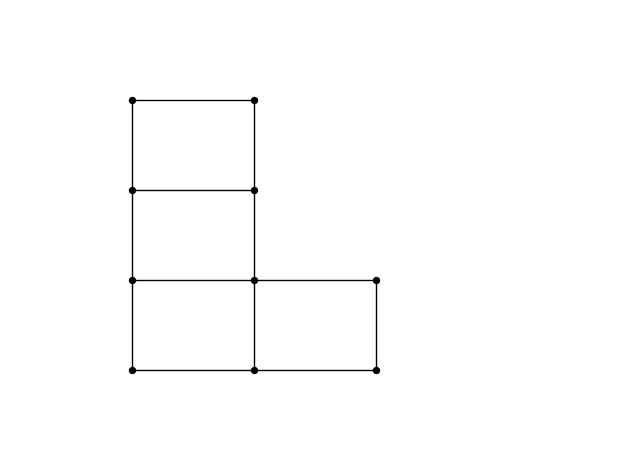

_sXP_[O@GD?JG?A?_OOAB??_?@G?@O??l???A??GG?@?G?B???G???C_??@O???J????_???@G???@O????k\n'
[(0, 0, 0), (0, 0, 1), (0, 1, 0), (1, 0, 0), (0, 1, 1), (1, 0, 1), (1, 1, 0), (1, 1, 1), (2, 0, 0), (2, 0, 1), (2, 1, 0), (2, 1, 1), (0, 2, 0), (0, 2, 1), (1, 2, 0), (1, 2, 1), (0, 3, 0), (0, 3, 1), (1, 3, 0), (1, 3, 1), (0, 0, 2), (0, 1, 2), (1, 0, 2), (1, 1, 2), (0, 0, 3), (0, 1, 3), (1, 0, 3), (1, 1, 3), (0, 0, 4), (0, 1, 4), (1, 0, 4), (1, 1, 4)]
Construction complete for d=3 with merged faces.
Total number of unique nodes: 32
Total number of edges: 60
Number of automorphisms:  1
{(0, 0, 0): (0, 0, 0), (0, 0, 1): (0, 0, 1), (0, 1, 0): (0, 1, 0), (1, 0, 0): (1, 0, 0), (0, 1, 1): (0, 1, 1), (1, 0, 1): (1, 0, 1), (1, 1, 0): (1, 1, 0), (1, 1, 1): (1, 1, 1), (2, 0, 0): (2, 0, 0), (2, 0, 1): (2, 0, 1), (2, 1, 0): (2, 1, 0), (2, 1, 1): (2, 1, 1), (0, 2, 0): (0, 2, 0), (0, 2, 1): (0, 2, 1), (1, 2, 0): (1, 2, 0), (1, 2, 1): (1, 2, 1), (0, 3, 0): (0, 3, 0), (0, 3, 1): (0, 3, 1), (1, 3, 0): (1, 3, 0), (1, 

/tmp/ipython-input-22-3214424293.py:126: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(*node_xyz.T, s=20, ec="w", c=(0,0,0), alpha=0.5)


<Figure size 800x800 with 0 Axes>

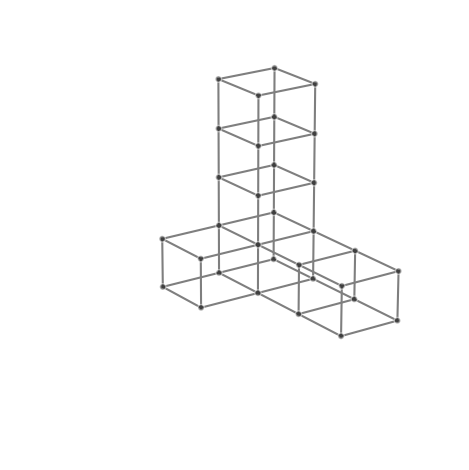

~?@_s`aaOoI?L?iE??o_EO?ZA??@?G?_O?GK?AG??PG?@D??AJC????_??_C??O?O?B??_?_?@?@G?@?@O??_?k???A?????OG???@@????AB????AG????@C_????PO????AJG??????C?????G@?????O?_????O?G????E?@????@O?@????E??A????F??????A???????@?_??????OO??????AC???????GW???????PO???????P_???????G[???????A?????????OG???????@@????????AC????????AE????????@D?????????P_????????AFO??????????C?????????GC?????????OA?????????O?G????????E?@????????@O?A????????E??A????????F??????????A???????????@?_??????????OO??????????AC???????????GW???????????PO???????????P_???????????G[???????????A?????????????OG???????????@@????????????AC????????????AE????????????@D?????????????P_????????????AF?????????????G??????????????OG?????????????OO?????????????GO?????????????AE??????????????PO?????????????@E??????????????AF\n'
[(0, 0, 0, 0), (0, 0, 0, 1), (0, 0, 1, 0), (0, 1, 0, 0), (1, 0, 0, 0), (0, 0, 1, 1), (0, 1, 0, 1), (1, 0, 0, 1), (0, 1, 1, 0), (1, 0, 1, 0), (0, 1, 1, 1), (1, 0, 1, 1), (1, 1, 0, 0), (1, 1, 0, 1), (1, 1, 1, 0), (1, 1, 1, 1), (2, 0, 

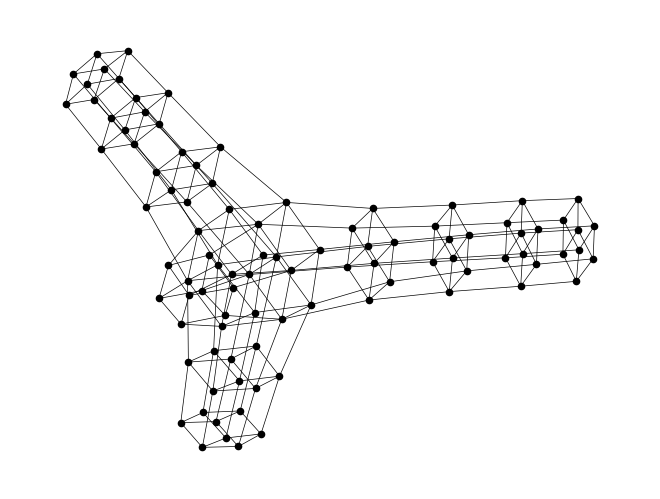

~?COsaBA`GP@_D?H??q?S_CcE??S??B?OA_G?KG?A`??BD??IIB????K??_?o?O?@_B??B?_??B@G??@`O???WkC?????C???G?C??@??A??B??@??G???O?C_??A?@O???G?J????_G????@?OG???@?OO????_GK????GAG????@?PG????C@D?????GAJA????????G??????_?_?????O?@?????B??A?????_??A????@G??@????@O???O????k???A???A?????O???OG???@???@@????A???AB????A???AG????@???@C_????O???PO????A???AJ????????_?????????@??G???????@??O????????_?K????????G?G????????@?@G????????C?D?????????G?J?????????GA??????????C@?_????????@?OO?????????GAB??????????_G_?????????@?PG?????????@?PO??????????_GkO?????????????O???????????G?O??????????@??G??????????B??A??????????G??@??????????G???O?????????AO??A??????????a???G?????????A_???O?????????H????O?????????HO???G?????????Gg????G????????B?????@?????????KG????C?????????X?????G?????????Z?????????????G???????????????C??_????????????@??O?????????????G?B??????????????_?_?????????????@?A??????????????@?AO??????????????_AG??????????????G?g??????????????@?H???????????????C?d???????????????GAI???????????????GB????????????????

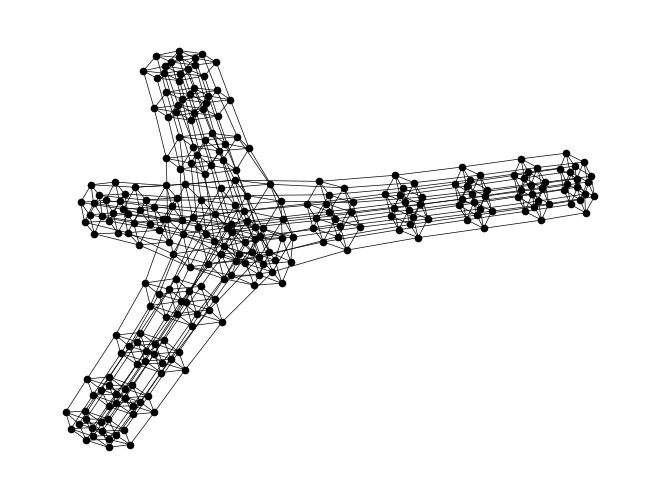

In [22]:

def construct_asymmetric_hypercube_merged(d):
    """
    Constructs an asymmetric graph by merging hypercubes along shared faces.

    This version uses a global coordinate system to identify vertices on shared
    faces, truly merging them rather than connecting them with extra edges.

    Args:
        d (int): The dimension of the hypercube.

    Returns:
        networkx.Graph: The constructed asymmetric graph.
    """
    if not isinstance(d, int) or d < 1:
        raise ValueError("Dimension 'd' must be a positive integer.")

    G = nx.Graph()
    # Store d in the graph's metadata for later use by other functions
    G.graph['d'] = d

    # 1. Define hypercube block coordinates in a global d-dimensional space.
    # The block coordinate defines the origin of each hypercube.
    hypercube_blocks = {}

    # The initial hypercube is at the origin
    hypercube_blocks[(0, 0)] = tuple([0] * d)

    # Define block coordinates for the gadget columns
    for i in range(1, d + 1):
        for j in range(1, i + 1):
            block_coord = [0] * d
            block_coord[i - 1] = j # The j-th cube in column 'i' is offset by 'j' along that dimension
            hypercube_blocks[(i, j)] = tuple(block_coord)

    # 2. Generate nodes and edges for each hypercube using global coordinates.
    # This process automatically merges nodes that lie on shared faces.
    for cube_id, block_coord in hypercube_blocks.items():
        # Generate 2^d local vertices for this hypercube
        local_vertices = list(itertools.product([0, 1], repeat=d))

        # Add edges based on local connectivity within the current hypercube
        for v1_local, v2_local in itertools.combinations(local_vertices, 2):
            # Two vertices are connected if their Hamming distance is 1
            hamming_dist = sum(c1 != c2 for c1, c2 in zip(v1_local, v2_local))
            if hamming_dist == 1:
                # Calculate the unique global coordinates for the two vertices
                node1_global = tuple(block_coord[k] + v1_local[k] for k in range(d))
                node2_global = tuple(block_coord[k] + v2_local[k] for k in range(d))

                # Adding the edge also adds the nodes to the graph if they don't exist yet
                G.add_edge(node1_global, node2_global)
    return G

def visualize_merged_graph(G, dim=2):
    """
    Creates a 2D visualization for the merged graph, suitable for d=2.
    """
    # For this model, the node identifiers (global coordinates) are their positions

    if dim == 2:
        plt.figure(figsize=(8, 8))
        pos = {node: node for node in G.nodes()}

        node_xyz = np.array([pos[v] for v in sorted(G)])
        edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

        # Create the 3D figure
        fig = plt.figure()

        ax = fig.add_subplot(111)
        ax.set_facecolor("white")
        # Plot the nodes - alpha is scaled by "depth" automatically
        ax.scatter(*node_xyz.T, s=40, ec="w", c=(0,0,0))

        # background to white

        # Plot the edges
        for vizedge in edge_xyz:
            ax.plot(*vizedge.T, color=(0,0,0), linewidth=1)


        def _format_axes(ax):
            """Visualization options for the 3D axes."""
            # Turn gridlines off
            ax.grid(False)
            # Suppress tick labels
            for dim in (ax.xaxis, ax.yaxis):
                dim.set_ticks([])
            # Set axes labels
            ax.set_xlabel("x")
            ax.set_ylabel("y")

            # x is longer
            ax.set_xlim(-1, 4)
            ax.set_ylim(-1, 4)

            # hide axes
            ax.set_axis_off()


        _format_axes(ax)
        fig.tight_layout()

    elif dim == 3:

        plt.figure(figsize=(8, 8))
        # pos = nx.spring_layout(G, iterations=2000, dim=3)

        # use labels as positions
        pos = {node: node for node in G.nodes()}


        print(pos)

        # nx.draw(graph, pos, with_labels=False, node_size=20, width=0.5, edge_color='black', node_color='black')
        # Extract node and edge positions from the layout
        node_xyz = np.array([pos[v] for v in sorted(G)])
        edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

        # Create the 3D figure
        fig = plt.figure()

        ax = fig.add_subplot(111, projection="3d")
        ax.set_facecolor("white")
        # Plot the nodes - alpha is scaled by "depth" automatically
        ax.scatter(*node_xyz.T, s=20, ec="w", c=(0,0,0), alpha=0.5)

        # background to white

        # Plot the edges
        for vizedge in edge_xyz:
            ax.plot(*vizedge.T, color="tab:gray")


        def _format_axes(ax):
            """Visualization options for the 3D axes."""
            # Turn gridlines off
            ax.grid(False)
            # Suppress tick labels
            for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
                dim.set_ticks([])
            # Set axes labels
            ax.set_xlabel("x")
            ax.set_ylabel("y")
            ax.set_zlabel("z")

            # x is longer
            ax.set_xlim(0, 4)
            ax.set_ylim(0, 4)
            ax.set_zlim(0, 4)

            # hide axes
            ax.set_axis_off()



        ax.view_init(elev=20, azim=55)
        _format_axes(ax)
        fig.tight_layout()


    else:
        pos = nx.spring_layout(G, iterations=2000)
        nx.draw(G, pos, with_labels=False, node_size=20, width=0.5, edge_color='black', node_color='black')

    plt.savefig(f"graph_dim{dim}.png")
    plt.show()



# --- Main execution block ---
if __name__ == '__main__':


    for d in range(2,6):
        asymmetric_graph = construct_asymmetric_hypercube_merged(d)
        print("graph6 string: ", str(nx.to_graph6_bytes(asymmetric_graph)).replace("b'>>graph6<<",""))
        print(asymmetric_graph.nodes())
        print(f"Construction complete for d={d} with merged faces.")
        print(f"Total number of unique nodes: {asymmetric_graph.number_of_nodes()}")
        print(f"Total number of edges: {asymmetric_graph.number_of_edges()}")
        print("Number of automorphisms: ", len(list(nx.vf2pp_all_isomorphisms(asymmetric_graph,asymmetric_graph))))

        visualize_merged_graph(asymmetric_graph, dim=d)

# Asymmetric depth VS Symmetrid difference - comparison

In [6]:
# prompt: compare asymmetric depth to minimum symmetric difference for those hypercubes from h = 2 to h =6

results = []

for h in range(2, 4):
    print(f"Processing h = {h}...")
    G = construct_asymmetric_hypercube_merged(h)

    n = G.number_of_nodes()
    print(n)
    print(nx.to_graph6_bytes(G))



    # Calculate Minimum Symmetric Difference
    min_sym_diff, min_sym_diff_pairs = find_min_symmetric_difference_neighbors(G)

    # Calculate Asymmetric Depth (using the _find_max_rank function)
    # The asymmetric_depth function itself includes the call to _find_max_rank
    relabeling = {node: i+1 for i, node in enumerate(G.nodes())}
    G = nx.relabel_nodes(G, relabeling)

    depth = asymmetric_depth(G)

    results.append({
        'h': h,
        'Order (n)': n,
        'Min Symmetric Difference (Nbr)': min_sym_diff,
        'Asymmetric Depth (d)': depth,
        'k (max partial auto rank)': n - depth
    })
    # print(f"h={h}: n={n}, Min Sym Diff={min_sym_diff}, Depth={depth}, k={n-depth}")
    print(results)

# Print comparison table
print("\n--- Comparison: Asymmetric Depth vs Minimum Symmetric Difference ---")
print("{:<5} | {:<8} | {:<28} | {:<18} | {:<10}".format(
    "h", "Order (n)", "Min Symmetric Difference (Nbr)", "Asymmetric Depth (d)", "k"
))
print("-" * 80)

for res in results:
    if 'Error' in res:
        print("{:<5} | {}".format(res['h'], res['Error']))
    else:
        print("{:<5} | {:<8} | {:<28} | {:<18} | {:<10}".format(
            res['h'],
            res['Order (n)'],
            res['Min Symmetric Difference (Nbr)'],
            res['Asymmetric Depth (d)'],
            res['k (max partial auto rank)']
        ))

# Analyze and summarize the relationship observed (optional)
print("\n--- Analysis ---")
# Based on the typical properties of Gamma_h, it is expected to be highly asymmetric.
# For a perfectly asymmetric graph, the identity is the only automorphism (full and partial).
# In this case, the definition of k (largest positive rank of non-trivial partial auto) might lead to k=0.
# If k=0, then depth = n - 0 = n.
# Min symmetric difference measures how 'similar' neighborhoods are. A smaller min difference
# suggests pairs of vertices with very similar local structure, which might hint at symmetry.
# However, Gamma_h is designed to avoid symmetry.
# For h >= 3, the expected minimum symmetric difference for Gamma_h is 2*(h-2).

# Compare the values
for res in results:
    if 'Error' not in res:
        h_val = res['h']
        n_val = res['Order (n)']
        min_diff_val = res['Min Symmetric Difference (Nbr)']
        depth_val = res['Asymmetric Depth (d)']
        k_val = res['k (max partial auto rank)']

        print(f"\nFor h={h_val}:")
        print(f"  Order (n): {n_val}")
        print(f"  Min Symmetric Difference (Nbr): {min_diff_val}")
        if h_val >= 3:
            expected_min_diff = 2 * (h_val - 2)
            print(f"  Expected Min Symmetric Difference (for h>=3): {expected_min_diff}")
        print(f"  Asymmetric Depth (d = n-k): {depth_val}")
        print(f"  Derived k: {k_val}")

Processing h = 2...
10
b'>>graph6<<IrGY?cA?W\n'
in depth:  9
[{'h': 2, 'Order (n)': 10, 'Min Symmetric Difference (Nbr)': 1, 'Asymmetric Depth (d)': 1, 'k (max partial auto rank)': 9}]
Processing h = 3...
32
b'>>graph6<<_sXP_[O@GD?JG?A?_OOAB??_?@G?@O??l???A??GG?@?G?B???G???C_??@O???J????_???@G???@O????k\n'
in depth:  31
in depth:  30
[{'h': 2, 'Order (n)': 10, 'Min Symmetric Difference (Nbr)': 1, 'Asymmetric Depth (d)': 1, 'k (max partial auto rank)': 9}, {'h': 3, 'Order (n)': 32, 'Min Symmetric Difference (Nbr)': 2, 'Asymmetric Depth (d)': 2, 'k (max partial auto rank)': 30}]

--- Comparison: Asymmetric Depth vs Minimum Symmetric Difference ---
h     | Order (n) | Min Symmetric Difference (Nbr) | Asymmetric Depth (d) | k         
--------------------------------------------------------------------------------
2     | 10       | 1                            | 1                  | 9         
3     | 32       | 2                            | 2                  | 30        

--- Analysis 

In [ ]:
graph = construct_gamma_h(4)


mapping = {v:i for i, v in enumerate(graph.nodes())}
reverse = {i:v for v, i in mapping.items()}
graph = nx.relabel_nodes(graph, mapping)

node_to_idx = {node: i for i, node in enumerate(graph.nodes())}
adj_dict = {
    node_to_idx[u]: [node_to_idx[v] for v in graph.neighbors(u)]
    for u in graph.nodes()
}

# Create the pynauty graph object.
pynauty_graph = pynauty.Graph(
    number_of_vertices=graph.order(),
    adjacency_dict=adj_dict
)
orbits = pynauty.autgrp(pynauty_graph)[3]

v_orbit_pair = [(i,o) for i, o in enumerate(orbits)]


graph = nx.relabel_nodes(graph, reverse)
v_orbit_pair = [(reverse[i],o) for i, o in v_orbit_pair]

print(v_orbit_pair)


[((0, 0, 0, 0), 0), ((0, 0, 0, 1), 1), ((0, 0, 0, 2), 2), ((0, 0, 0, 3), 3), ((0, 0, 1, 0), 1), ((0, 0, 1, 1), 5), ((0, 0, 1, 2), 6), ((0, 0, 1, 3), 7), ((0, 0, 2, 0), 2), ((0, 0, 2, 1), 6), ((0, 0, 2, 2), 10), ((0, 0, 2, 3), 11), ((0, 0, 3, 0), 3), ((0, 0, 3, 1), 7), ((0, 0, 3, 2), 11), ((0, 0, 3, 3), 15), ((0, 1, 0, 0), 16), ((0, 1, 0, 1), 17), ((0, 1, 0, 2), 18), ((0, 1, 0, 3), 19), ((0, 1, 1, 0), 17), ((0, 1, 1, 1), 21), ((0, 1, 1, 2), 22), ((0, 1, 1, 3), 23), ((0, 1, 2, 0), 18), ((0, 1, 2, 1), 22), ((0, 1, 2, 2), 26), ((0, 1, 2, 3), 27), ((0, 1, 3, 0), 19), ((0, 1, 3, 1), 23), ((0, 1, 3, 2), 27), ((0, 1, 3, 3), 31), ((0, 2, 0, 0), 32), ((0, 2, 0, 1), 33), ((0, 2, 0, 2), 34), ((0, 2, 0, 3), 35), ((0, 2, 1, 0), 33), ((0, 2, 1, 1), 37), ((0, 2, 1, 2), 38), ((0, 2, 1, 3), 39), ((0, 2, 2, 0), 34), ((0, 2, 2, 1), 38), ((0, 2, 2, 2), 42), ((0, 2, 2, 3), 43), ((0, 2, 3, 0), 35), ((0, 2, 3, 1), 39), ((0, 2, 3, 2), 43), ((0, 2, 3, 3), 47), ((0, 3, 0, 0), 48), ((0, 3, 0, 1), 49), ((0, 3, 0, 

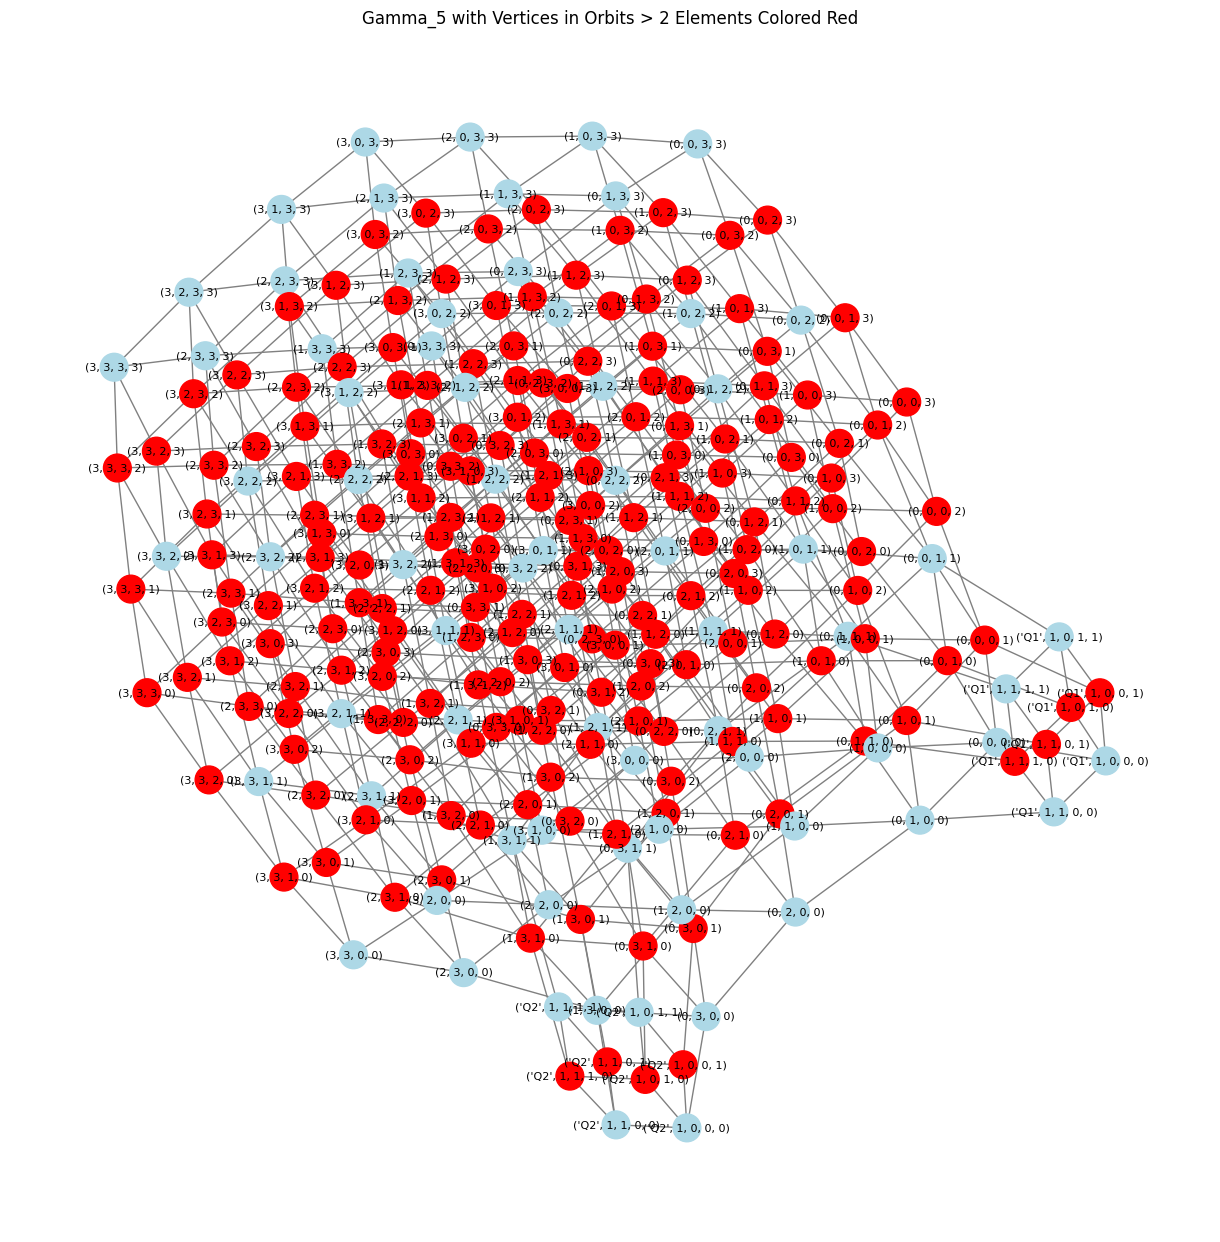

In [ ]:
# prompt: draw the graph, color only the vertices which belong to orbits that have more than two elements, v_orbit_pair contains label, orbit pairs

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(graph, iterations=1000) # Use the same layout for consistency

# Determine which nodes to color based on orbit size
orbit_sizes = {}
for node, orbit in v_orbit_pair:
    if orbit not in orbit_sizes:
        orbit_sizes[orbit] = 0
    orbit_sizes[orbit] += 1

node_colors = []
for node in graph.nodes():
    # Find the orbit ID for the current node
    current_orbit = None
    for v, o in v_orbit_pair:
        if v == node:
            current_orbit = o
            break

    if current_orbit is not None and orbit_sizes.get(current_orbit, 0) >= 2:
        node_colors.append('red') # Color nodes in orbits > 2 elements
    else:
        node_colors.append('lightblue') # Default color for others

# Draw the graph
nx.draw(
    graph,
    pos,
    with_labels=True,
    node_color=node_colors,
    edge_color='gray',
    node_size=400,
    font_size=8
)

plt.title(f"Gamma_{h} with Vertices in Orbits > 2 Elements Colored Red")
plt.show()

In [9]:
!pip install julia

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 1.9 MB/s eta 0:00:00


In [11]:
import julia
julia.install()


Precompiling PyCall...
Precompiling PyCall... DONE
PyCall is installed and built successfully.


In [17]:
!pip install juliacall
!pip install juliapkg


In [23]:
from juliacall import Main as jl

from juliapkg import add

add("NautyGraphs", uuid="7509a0a4-015a-4167-b44b-0799a1a2605e")


In [ ]:
jl.seval("using Combinatorics")

In [ ]:
!git clone https://github.com/your_username/your_repository.git